<center><h1>CSCI 5481 Final Project</h1>
    <h3>Brian Cooper</h3>
</center>

<hr>
<br>

In [3]:
%matplotlib inline

# Import datasets and SVM methods
from data import *
from svm import *

## Plot Data

### __TODO__ Shuffle mouse proteome matrix

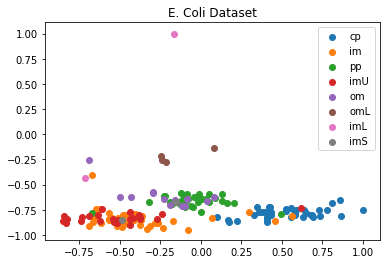

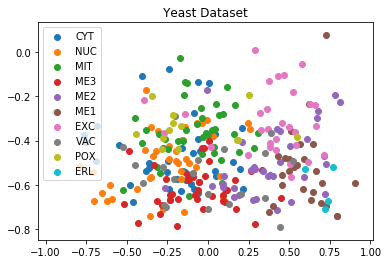

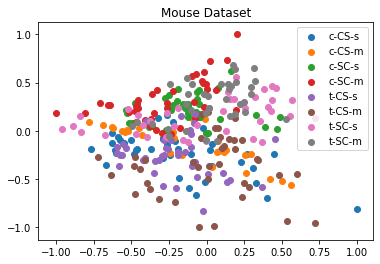

In [4]:
# Ecoli
e_sample_total, e_training_input, e_test_input, e_class_labels = ecoli(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Yeast
y_sample_total, y_training_input, y_test_input, y_class_labels = yeast(training_size=40, test_size=10, n=2, PLOT_DATA=True)

# Mouse
m_sample_total, m_training_input, m_test_input, m_class_labels = mouse(training_size=40, test_size=10, n=2, PLOT_DATA=True)

## Perform Quantum SVM

In [ ]:
# e_result_quantum = quantum_svm(e_training_input, e_test_input, e_class_labels, 2)
# print("E. Coli QSVM classification done")

# y_result_quantum = quantum_svm(y_training_input, y_test_input, y_class_labels, 2)
# print("Yeast QSVM classification done")

# m_result_quantum = quantum_svm(m_training_input, m_test_input, m_class_labels, 2)
# print("Mouse QSVM classification done")

## Perform Classical SVM

In [ ]:
e_result_classical = classical_svm(e_training_input, e_test_input, e_class_labels, 2)
print("E. Coli SVM classification done")

y_result_classical = classical_svm(y_training_input, y_test_input, y_class_labels, 2)
print("Yeast SVM classification done")

m_result_classical = classical_svm(m_training_input, m_test_input, m_class_labels, 2)
print("Mouse SVM classification done")

## Compare Classical SVM and QSVM

I used the accuracy results as a metric to measure the performance.

In [ ]:
print("   E. Coli Dataset Accuracy   ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(e_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(e_result_quantum['testing_accuracy']))
print("------------------------------\n")

print("    Yeast Dataset Accuracy    ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(y_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(y_result_quantum['testing_accuracy']))
print("------------------------------\n")

print("    Mouse Dataset Accuracy    ")
print("------------------------------")
print("SVM (Radial Basis):       {:.2f}".format(m_result_classical['testing_accuracy']))
# print("Quantum SVM:              {:.2f}".format(m_result_quantum['testing_accuracy']))
print("------------------------------\n")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

blue = (0.43, 0.65, 0.78, 0.8)
purple = (0.43, 0.25, 0.78, 0.8)

x = np.arange(2)
# e_accuracy = [0.9, 0.6]
# y_accuracy = [0.45, 0.43]
# m_accuracy = [0.75, 0.9]

# Ecoli Accuracy
plt.bar(x, e_accuracy, color=[blue, purple])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("E. Coli Accuracy", fontsize=18)
plt.show()

# Yeast Accuracy
plt.bar(x, y_accuracy, color=[blue, purple])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Yeast Accuracy", fontsize=18)
plt.show()

# Mouse Accuracy
plt.bar(x, m_accuracy, color=[blue, purple])
plt.xticks(x, ('SVM', 'QSVM'), fontsize=13.5)
plt.title("Mouse Accuracy", fontsize=18)
plt.show()